In [1]:
# Import high level Keras API for tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import library for querying for GPU information
from tensorflow.python.client import device_lib

If using Google colab, be sure to enable hardware acceleration by following the instructions at https://colab.research.google.com/notebooks/gpu.ipynb

In [3]:
# Make sure that we are using GPUs for now. If we are not, then we should abort.
gpus = tf.config.list_physical_devices('GPU')
assert(len(gpus) > 0)

# TODO #6: It would be good to query for information about the GPU here so that
# we can make decisions which allow the code to be portable to devices with
# varying amounts of resources.
devices_info = device_lib.list_local_devices()
gpus_info = [device for device in devices_info if "GPU" in device.name]

Next we will define our standard implementation of PPO. For a good overview of how PPO works, there is an excellent resource at https://www.youtube.com/watch?v=5P7I-xPq8u8&t=1s&ab_channel=ArxivInsights

The pseudocode from the paper is below:

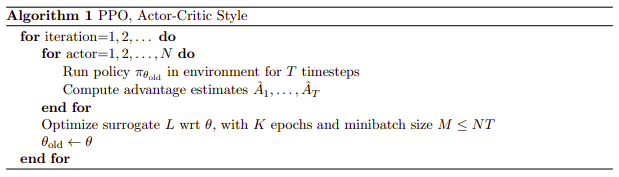

We start by creating a an Actor Critic model to build around. The tensorflow documentation has an implementation which has shared hidden layers, allowing for less computation.

https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

In [4]:
# This code is basically entirely from the tensorflow tutorial

class SimpleActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(self, num_actions, num_hidden_units):
    """Initialize."""
    super().__init__()

    # Use RELU activation and a common hidden layer the actor and critic
    # networks to hopefully help reduce computation. If we want, we can
    # make common a Sequential set of layers for more complex functionality.
    # For now, keep it simple.
    self.common = layers.Dense(num_hidden_units, activation="relu")

    # Actor and critic both output real numbered values, so default to no
    # activation function on output
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs):
    # Ensure that the common hidden layer is used for both actor and critic
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

Now we have our Actor Critic model, but we don't actually need the value function for PPO... we need the advantage function. The advantage function is tracking the *advantage* of taking one action over others in a particular state. This is simply the Q value of that particular state action pair subtracting out the value of being in that state: $A^{\pi}(s_t,a_t) = Q^{\pi}(s_t,a_t)-V^{\pi}(s_t)$

Our actor critic model is already giving us an estimate of the value function $\hat{V}^{\pi}(s_t)$, so now we need to try to find the value of $Q^{\pi}(s_t,a_t)$ and we will be all set! Well, we are not tracking that.

Fortunately, there is an alternative estimator for the advantage function known as the generalized advantage estimation (GAE).  There is an explanation of this function over at https://jonathan-hui.medium.com/rl-policy-gradients-explained-advanced-topic-20c2b81a9a8b, but basically this estimator takes the form $\hat{A}^{\pi}_n(s_t,a_t)=\sum^{t+n-1}_{t'=t}\gamma^{t'-t}r(s_{t'},a_{t'})-\hat{V}^{\pi}(s_t)+\gamma^n\hat{V}^{\pi}(s_{t+n})$. In this function, $n$ is the n step lookahead and $t$ is the current time step. What we are essentially doing is looking at the expected n-step return for an epsidoe, subtracting the value of the current state, and adding in the discounted value of the state n steps into the future. This is intuitively similar to our previous definition of the advantage function using the Q value, as it takes a set of real state action pairs, calculates the actual values for the epsiode, and uses the estimate of the resulting state. This is a high-variance estimate of the Q value, but the Q value is what we were looking for!

Going back to the n-step return, n is a free parameter that lets us balance between pure TD learning (where $n=0$) and monte carlo runs (where $n$ is the full episode). We don't have to specifically pick one of those two, but in our case, one simple approach computationally is to roll out entire episodes, using monte carlo runs. By doing this, the term $\gamma^n\hat{V}^{\pi}(s_{t+n})$ goes to 0 as the value of the terminal state is 0. This leaves us with an advantage estimate of $\hat{A}^{\pi}_n(s_t,a_t)=\sum^{\infty}_{i}\gamma^{i}r_{t+i}-\hat{V}^{\pi}(s_t)$. It is also worth noting that $\sum^{\infty}_{i}\gamma^{i}r_{t+i}$ in our case will not go to infinity, but rather it will terminate at the end of each episode, which will terminate at some time step $T$. This means that we are working with $\sum^{T}_{i}\gamma^{i}r_{t+i}$ is equal to our episode return starting at timestep t, or $G_t$. This ultimately leaves us with an advantage estimate of $\hat{A}^{\pi}_n(s_t,a_t)=G_t-\hat{V}^{\pi}(s_t)$. This is something we can work with, as we will have episodic roll-outs to compute the expceted return $G_t$ for each timestep and our actor critic model will be returning an estimate of the value $V(s_t)$ at each timestep! We now have a mechanism to calculate an estimate under our policy for the advantage function at each time step for an episode.

Once again, there is an existing implementation in the tensorflow Actor Critic example, so we will draw from that for our implementation.

In [5]:
def get_expected_return(rewards, gamma, standardize):
  """Compute expected returns per timestep."""

  # Get the number of rewards to accumulate for the epsiode
  n = tf.shape(rewards)[0]

  # Create a returns dynamic array
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array. This lets us iteratively accumulate
  # discount factor to avoid needing to raise the discount factor
  # to a power for each iteration. It also lets us calculate the
  # return for each timestep independently.
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)

  # Initialize the sum to 0
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape

  # Iterate over all rewards in the episode
  for i in tf.range(n):
    reward = rewards[i]

    # Accumulate the return after i steps in the episode
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)

    # Save the return for the (n-i)th step
    returns = returns.write(i, discounted_sum)
  
  # Convert the returns for each time step to a tensor
  returns = returns.stack()[::-1]

  # Optionally standardize the returns for stability in training
  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

Next, we will need to define an implementation of our loss function. The loss function defined in the paper is as follows:

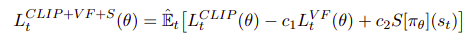

In layman's terms, this is basically saying to use a clipping objective, subtract off a scaled down loss of the critic (which in our case is taken from the advantage), and add in a scaled down bonus for an entropy term. We should cover each of these in detail.

$L^{CLIP}_t(\theta)=\hat{\mathbb{E}}_t[\min{(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta),1-\epsilon,1+\epsilon))}]$ where $r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$.

This deserves its own deep dive. The term $r_t(\theta)$ is roughly measuring how a current policy deviates from a previous iteration from the policy. If the two policies are identical, then this value will be exactly 1. The more that the new policy deviates from the old policy, the more different these values will be.

The goal is to try and limit deviations from the previous policy to the current policy by trying to limit how large of a step gets taken when the policy change appears to be heading in the right direction. By clipping the loss function in this way, the gradient that gets backpropogated will be conservative if the step taken was in a good direction, but it need not be conservative if the step taken was in a very poor direction from what was present in the original policy. The end result is that the training process tends to be more stable in the policy space.

The next two terms in our overall loss function were $-c_1L^{VF}_t(\theta)+c_2S[\pi_\theta](s_t)$. The values $c_1,c_2$ are hyperparameters which control the contribution of the other two terms. The term $L^{VF}_t(\theta)$ is simply our critic loss, which can be implemented using some standard regression loss formula (the paper uses MSE) for our advantage estimate of $G_t-\hat{V}^{\pi}(s_t)$. The value $S[\pi_\theta](s_t)$ is an entropy bonus, where we are essentially trying to maximize the entropy of the distribution of actions for a given state. The generic formula for entropy is $-\sum p(x)\log(x)$ for some probability distribution $p(x)$. In this case, our distribution is the policy in a given state, or a sample at some time step of our actor output.

The below code is based once again on the Tensorflow actor critic example, but since this is for PPO, we start to diverge from their implementation.

In [6]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_ppo_loss(new_action_probs, old_action_probs, values, returns, c1, c2, epsilon=0.2):
  """Computes the proximal policy loss."""

  # Calculate the advantage
  advantage = returns - values

  # TODO: this should be optimized to reduce computation

  # The log of a product is the sum of the logs, so take the log of the
  # action probabilities, subtract what would have been the divisor from what
  # would have been the numerator, and then raise back up to the original
  # space. This has the same effect as dividing the two.
  new_action_log_probs = tf.math.log(new_action_probs)
  old_action_log_probs = tf.math.log(old_action_probs)
  r = tf.math.exp(new_action_log_probs - old_action_log_probs)

  # Compute the clipped value of r to ensure that we are not too aggressive in
  # updates in policy space which we think are going in the right direction.
  clipped_r = tf.clip_by_value(r, 1 - epsilon, 1 + epsilon)
  actor_loss = tf.math.minimum(r, clipped_r)

  # We can use any loss function. Use huber loss, which is less sensitive to
  # outliers than RMSE and friends.
  # TODO: investigate if the order of the parameters matters for calculation
  # of the gradient given that the critic loss in the paper is negative
  critic_loss = huber_loss(values, returns)

  # Calculate the entropy, which will be used to encourage exploration
  entropy = tf.math.reduce_sum(new_action_probs * new_action_log_probs) * -1

  ppo_loss = actor_loss - c1 * critic_loss + c2 * entropy 

  return ppo_loss